In [58]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

In [59]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']

training_path    = '../../../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

In [60]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [61]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [76]:
FRAME_SIZE = 256 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [63]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [64]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [65]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [66]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [67]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [68]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

podría ser en la componente 3 evaluando la media entre el 60 y el 80 por ciento

In [92]:
def spectral_flux(signal):

    # Calcular el espectrograma de magnitudes
    spectrogram = np.abs(librosa.stft(signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))

    # Calcular el flujo espectral
    spectral_flux_values = np.sum(np.diff(spectrogram, axis=1)**2, axis=0)

    return spectral_flux_values

In [97]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [98]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

Podría ser el máximo de la componente 1 del MFCC entre 60 y 90 por ciento de la duración del audio o bien el mínimo del BER entre el 60 y 80 por ciento de la duración del audio para el agrupamiento de las bananas y la separación respecto de las naranjas.

C:\Users\Juan\AppData\Local\Temp\ipykernel_7720\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


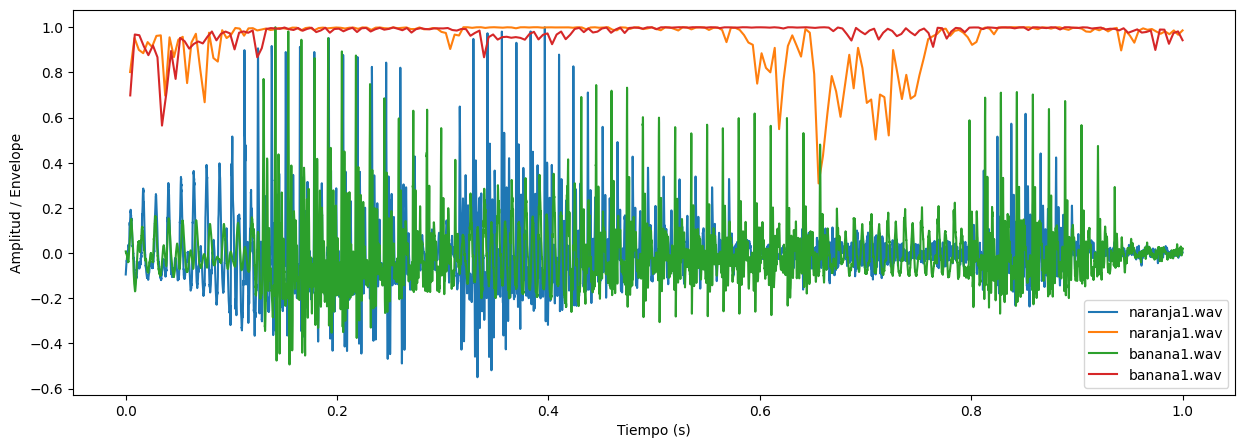

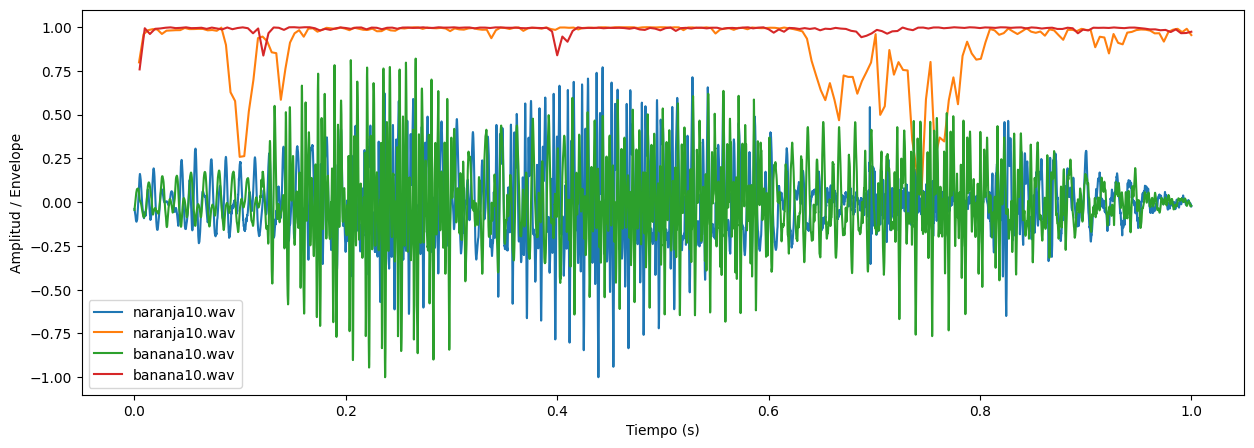

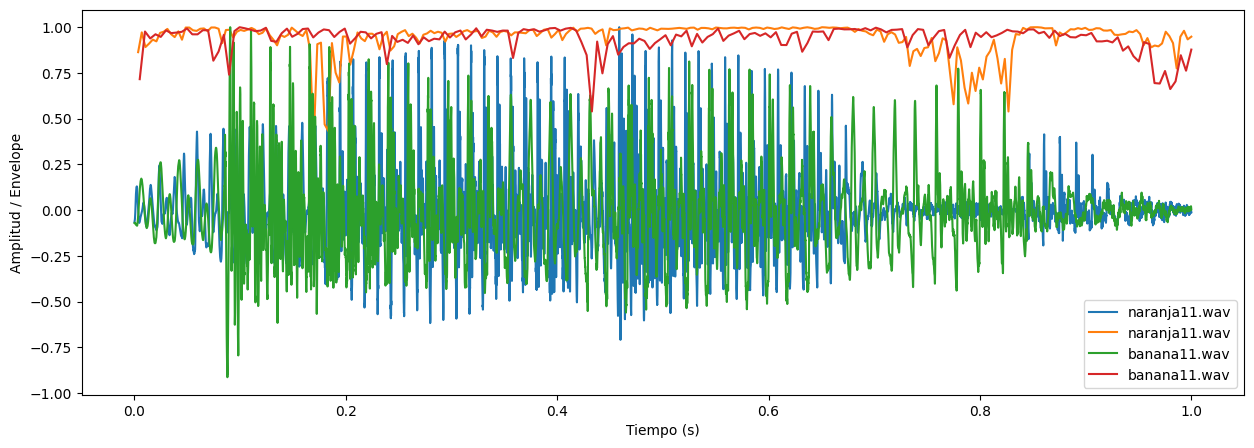

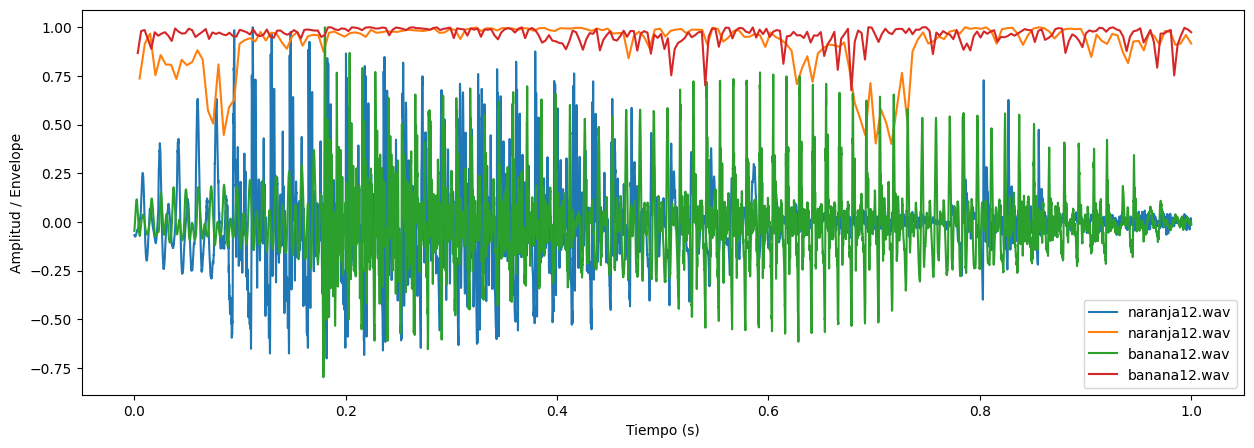

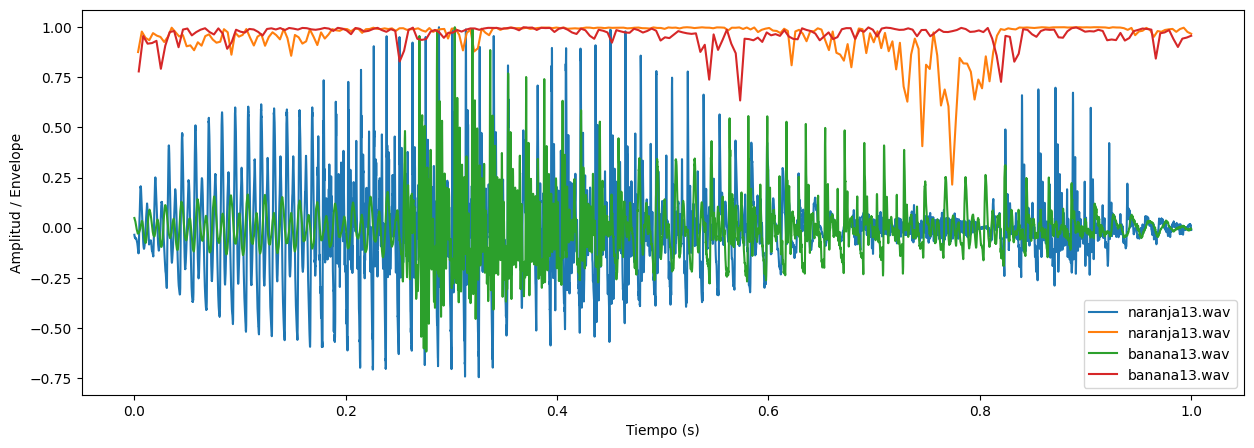

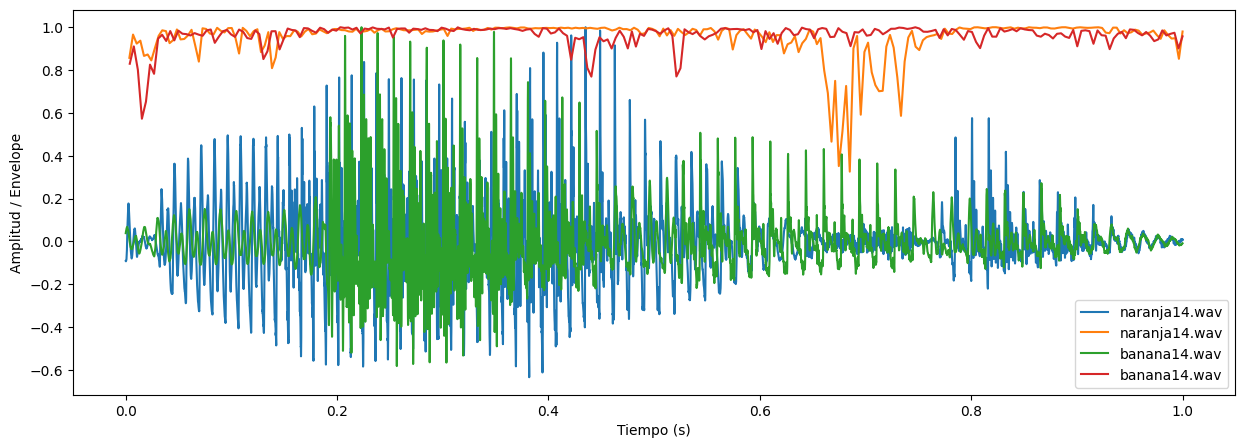

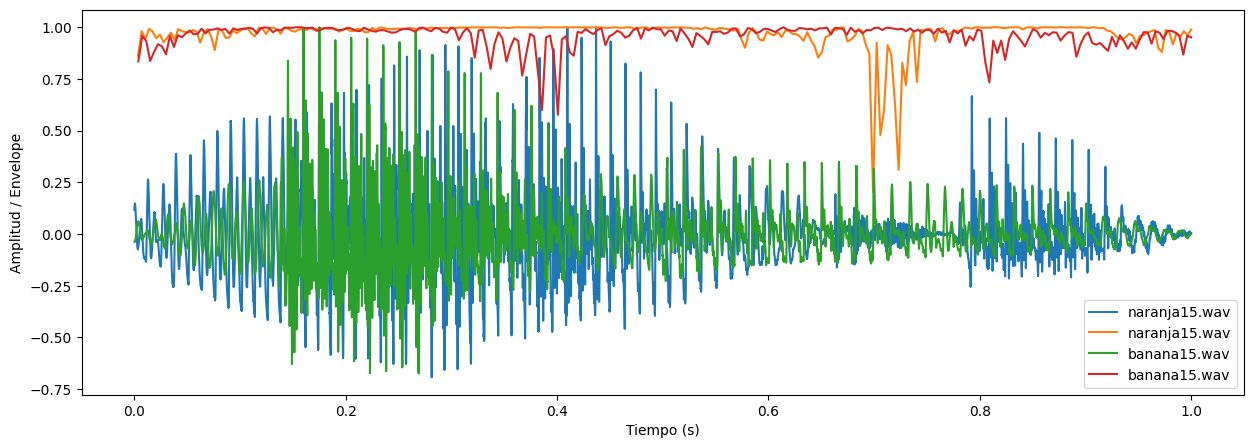

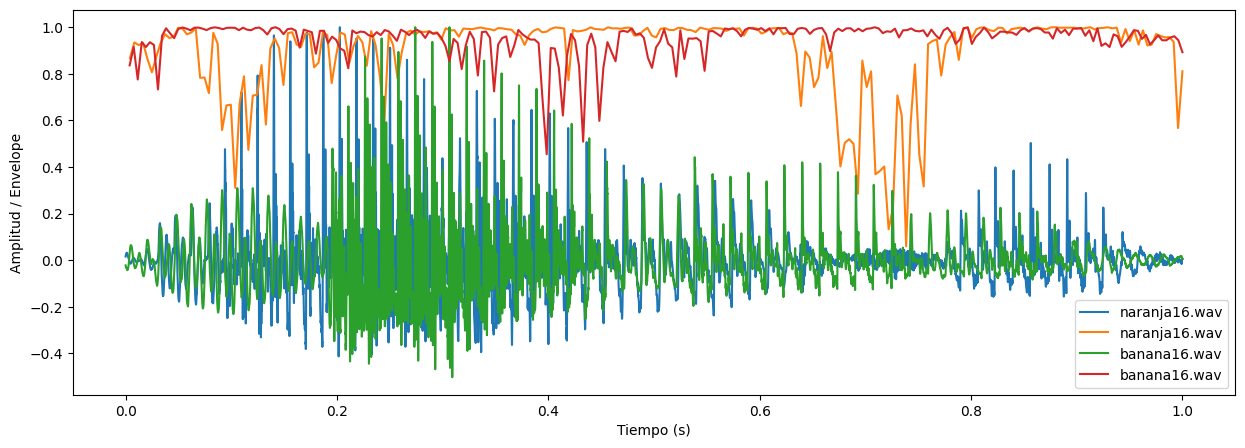

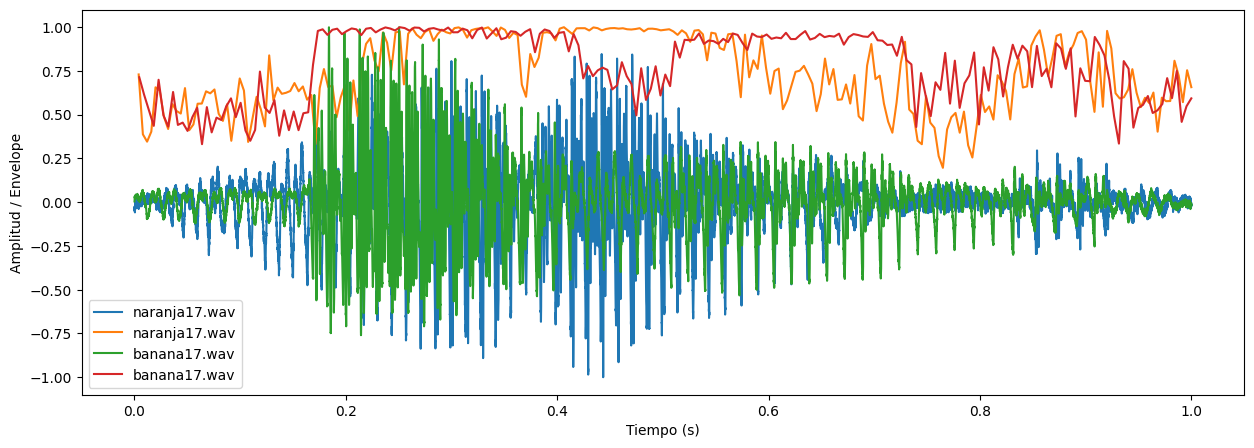

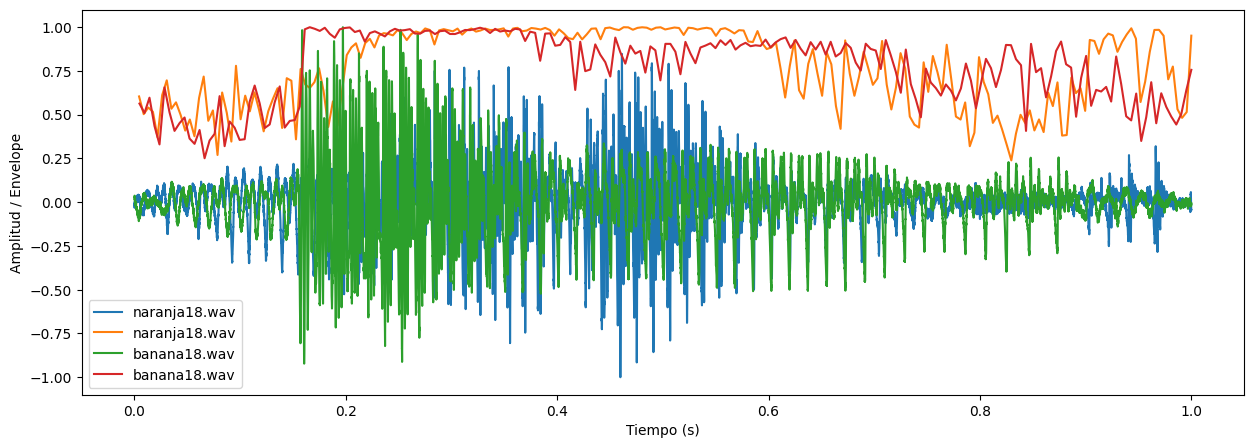

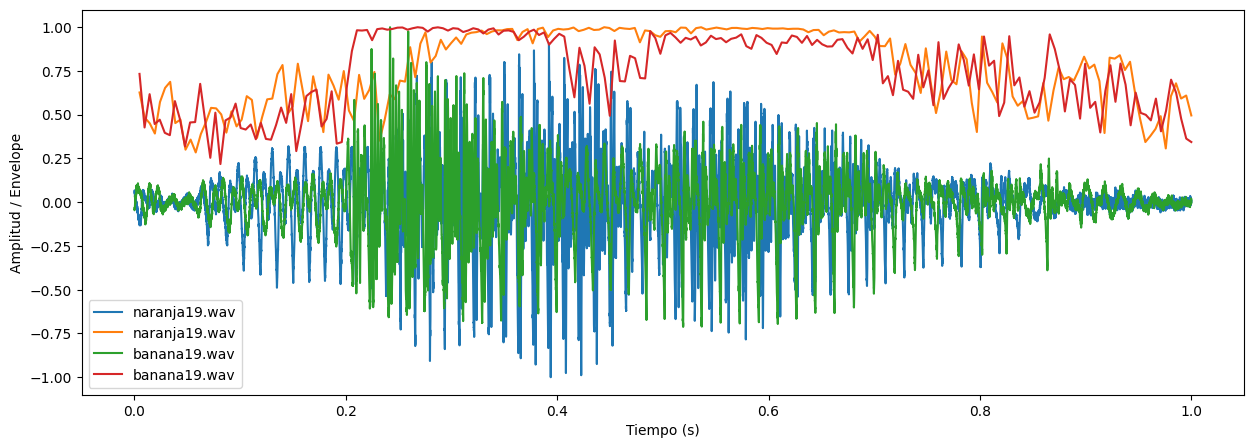

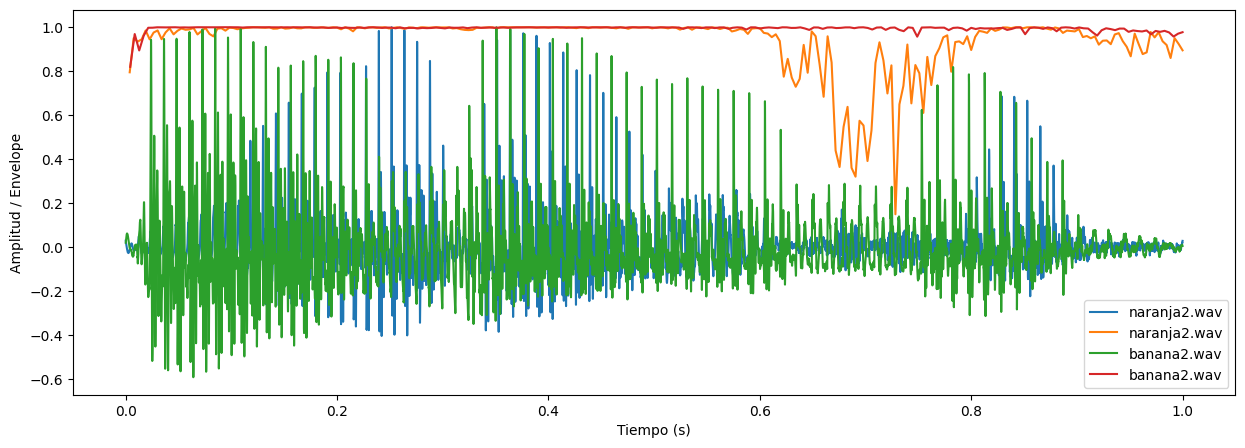

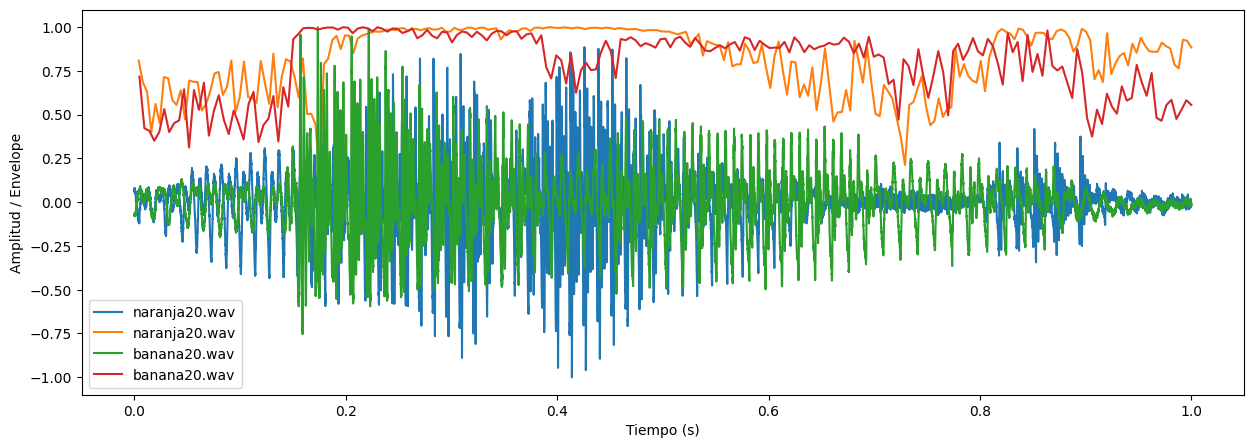

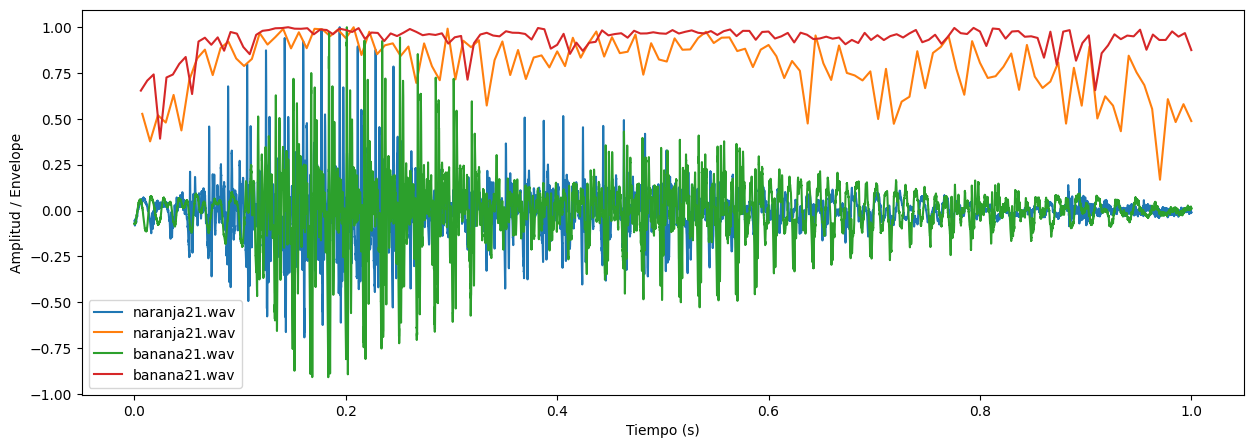

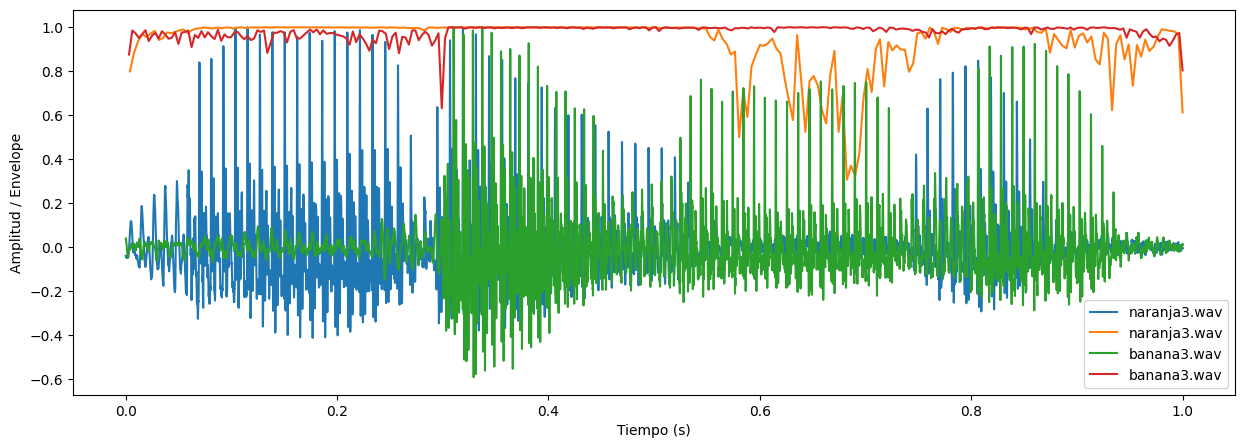

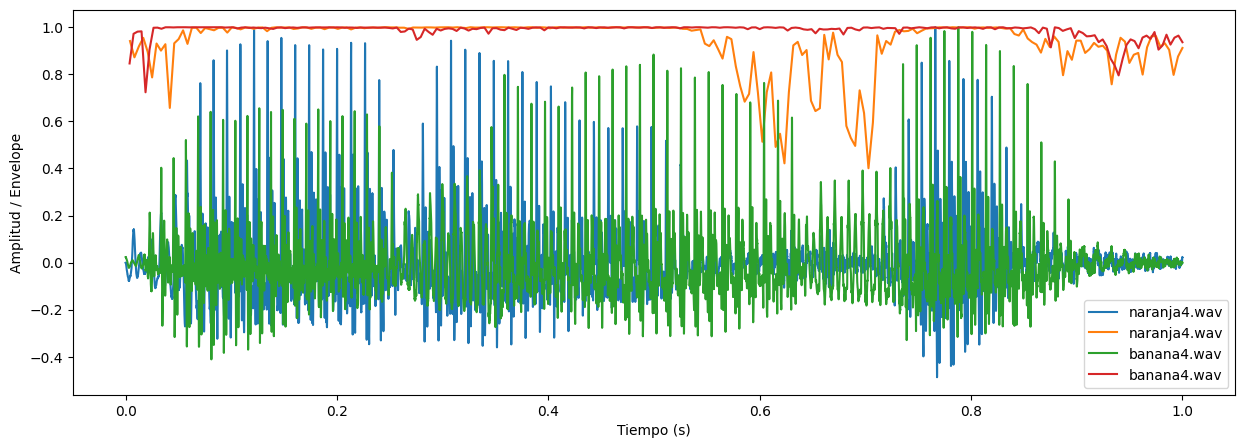

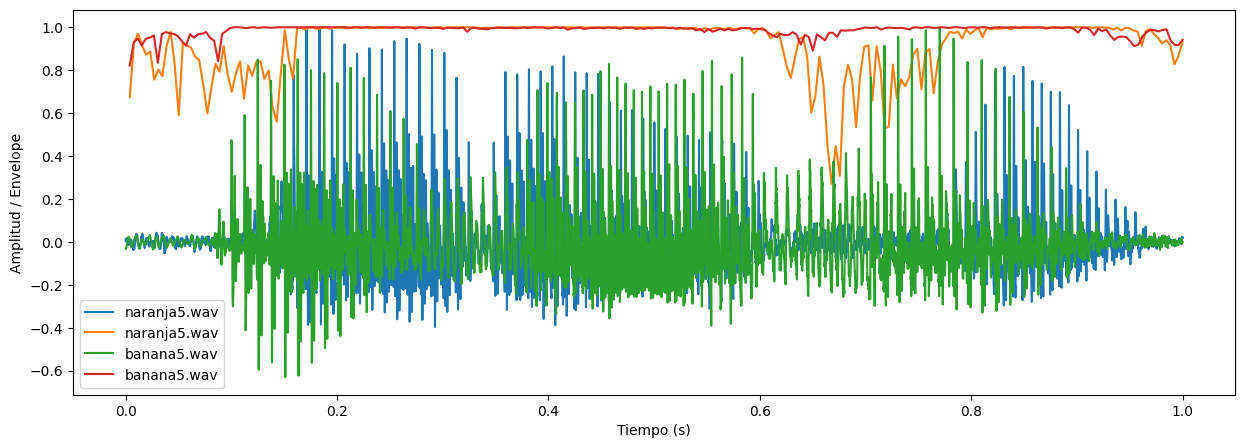

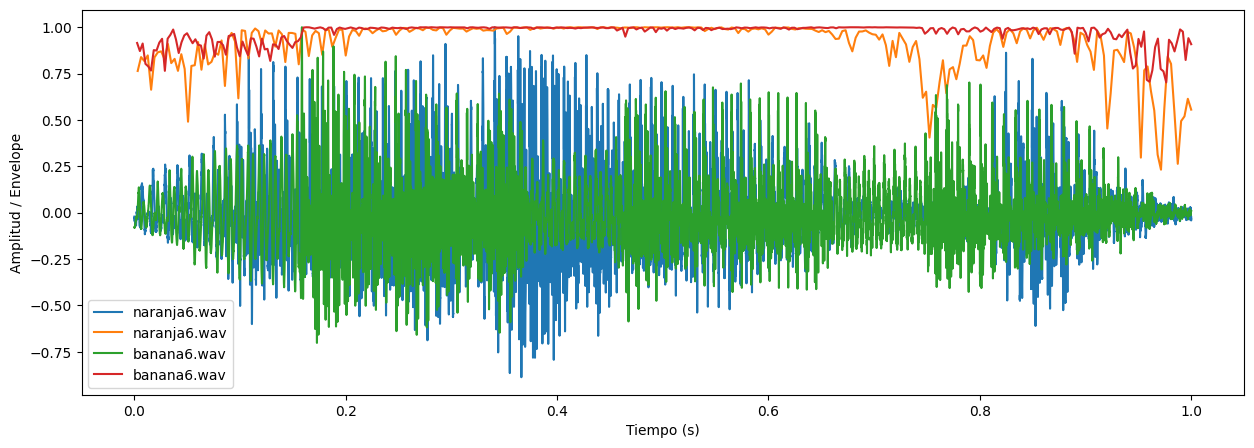

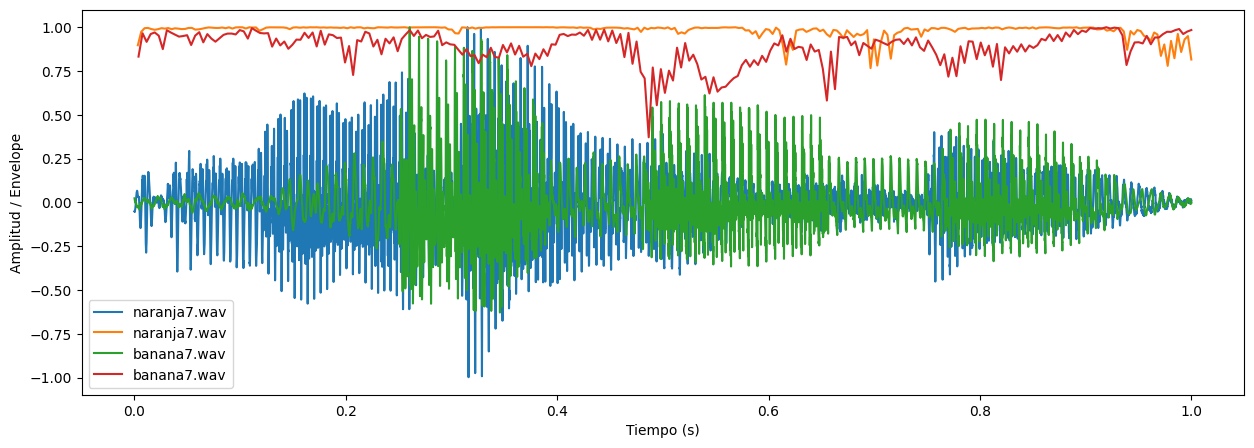

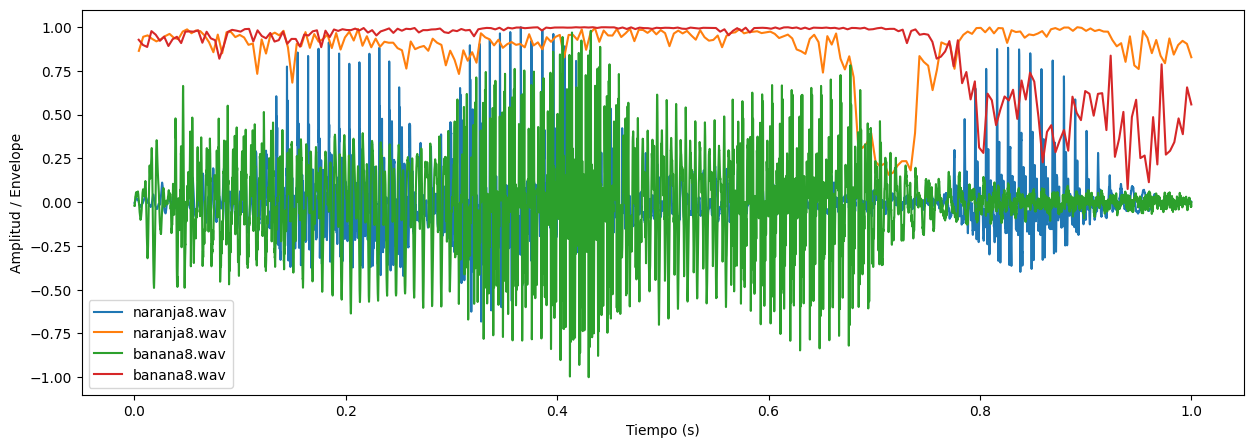

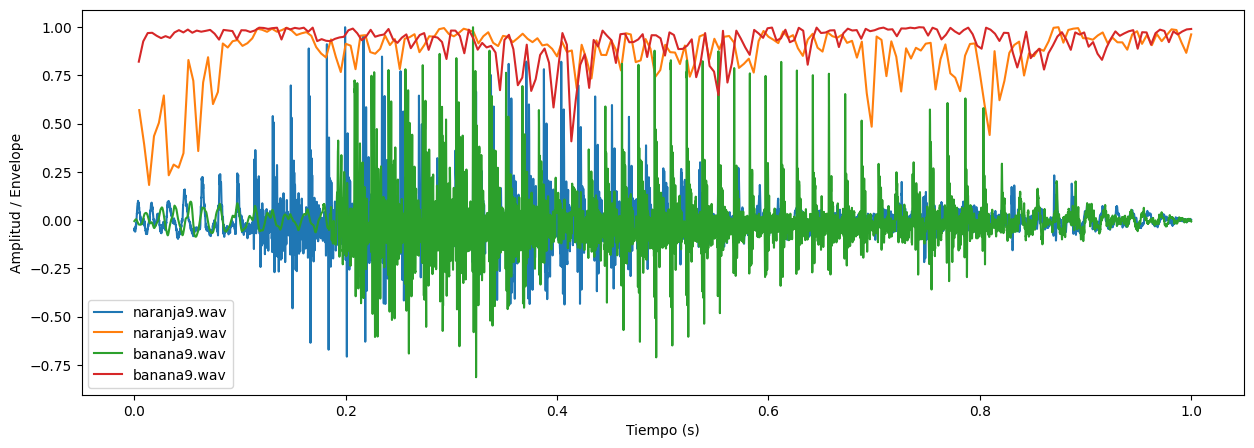

In [100]:
features = dict.fromkeys(fruit_types)
split_frequency = 2000
# Extracción de características
n_mfcc = 13
componente = 4
for i, audio in enumerate(processed['naranja']):
    cutoff = 10000
    cuton = 1000

    signal, sr, duration = load_audio(audio)
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    spec = librosa.stft(filtered, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(BER)

    frames = range(len(BER))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    t /= t[-1]
    plt.figure(figsize=(15, 5))
    tsig = librosa.times_like(signal, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)
    plt.plot(tsig/tsig[-1], signal/np.max(np.abs(signal)), label = os.path.basename(audio))
    plt.plot(t, BER, label=os.path.basename(audio))

    '''signal, sr, duration = load_audio(audio)
    signal = band_pass_filter(signal, sr, cuton, cutoff)
    filtered = band_pass_filter(filtered, sr, cuton, cutoff)
    flux = spectral_flux(signal)
    flux/=np.max(np.abs(flux))
    frames = range(len(flux))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    t /= t[-1]
    plt.figure(figsize=(15, 5))
    tsig = librosa.times_like(signal, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)
    plt.plot(tsig/tsig[-1], signal/np.max(np.abs(signal)), label = os.path.basename(audio))
    plt.plot(t, flux, label=os.path.basename(audio))'''
    '''
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)'''

    #filtered = band_pass_filter(signal, sr, cuton, cutoff)
    '''zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    frames = range(len(zcr))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    t /= t[-1]
    plt.figure(figsize=(15, 5))
    tsig = librosa.times_like(signal, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)
    plt.plot(tsig/tsig[-1], signal/np.max(np.abs(signal)), label = os.path.basename(audio))
    plt.plot(t, zcr, label=os.path.basename(audio))'''
    '''plt.figure(figsize=(15, 5))
    frames = range(mfccs.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    t /= t[-1]

    tsig = librosa.times_like(signal, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)
    plt.plot(tsig/tsig[-1], signal/np.max(np.abs(signal)), label = os.path.basename(audio))
    plt.plot(t, mfccs[componente,:], label=os.path.basename(audio))'''
             
   

    '''filtered = band_pass_filter(signal, sr, cuton, cutoff)
    zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
    zcr /= np.max(np.abs(zcr))
    frames = range(len(zcr))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    t /= t[-1]
    tsig = librosa.times_like(signal, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)'''
    '''audio = processed['banana'][i]
    signal, sr, duration = load_audio(audio)
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    mfccs = librosa.feature.mfcc(y = filtered, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

    frames = range(mfccs.shape[1])
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    t /= t[-1]
    tsig = librosa.times_like(signal, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)'''
    '''audio = processed['banana'][i]
    signal, sr, duration = load_audio(audio)
    signal = band_pass_filter(signal, sr, cuton, cutoff)
    filtered = band_pass_filter(filtered, sr, cuton, cutoff)
    flux = spectral_flux(signal)
    flux/=np.max(np.abs(flux))
    frames = range(len(flux))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    t /= t[-1]
    tsig = librosa.times_like(signal, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)
    plt.plot(tsig/tsig[-1], signal/np.max(np.abs(signal)), label = os.path.basename(audio))
    plt.plot(t, flux, label=os.path.basename(audio))'''
    '''plt.plot(t, mfccs[componente,:], label=os.path.basename(audio))'''
    audio = processed['banana'][i]
    signal, sr, duration = load_audio(audio)
    filtered = band_pass_filter(signal, sr, cuton, cutoff)
    spec = librosa.stft(filtered, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    BER  = band_energy_ratio(spec, split_frequency, sr)
    BER /= np.max(BER)

    frames = range(len(BER))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    t /= t[-1]
    tsig = librosa.times_like(signal, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)
    plt.plot(tsig/tsig[-1], signal/np.max(np.abs(signal)), label = os.path.basename(audio))
    plt.plot(t, BER, label=os.path.basename(audio))
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud / Envelope')
    plt.legend()  # Mostrar leyenda con etiquetas
    plt.show()
